In [102]:
pip install keras==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [103]:
BATCH_SIZE = 500  
EPOCH = 30
LSTM_STATE_SIZE = 200 
DROPOUT = 0.5         #between input and hidden layer     
DROPOUT_RECURRENT = 0.25    #between hidden layers
EMB_SIZE = 50

In [104]:
def readfile(filename, *, encoding="UTF8"):
  with open(filename, mode='rt', encoding=encoding) as f:
    sentences = []
    sentence = []
    for line in f:
      line = line[:-1]
      if len(line) == 0 or line[0] == "\n":
        if len(sentence) > 0:
          sentences.append(sentence)
          sentence = []
        continue
      splits = line.split(' ')
      sentence.append([splits[0], splits[-1]])

  if len(sentence) > 0:
    sentences.append(sentence)
    sentence = []
  return sentences


train = readfile("/content/drive/MyDrive/data/train.txt")
dev = readfile("/content/drive/MyDrive/data/valid.txt")
test = readfile("/content/drive/MyDrive/data/test.txt")

In [105]:
words = set()
tags = set()
for sentence in train:
  for word, tag in sentence:
    words.add(word.lower())
    tags.add(tag)
n_words = len(words)
n_tags = len(tags)
print(tags)
print(n_words, n_tags)

{'I-ORG', 'B-ORG', 'B-PER', 'B-LOC', 'B-MISC', 'I-LOC', 'O', 'I-MISC', 'I-PER'}
21010 9


In [106]:
word2idx = {w:i+2 for i, w in enumerate(words)}
word2idx["PAD"] = 0
word2idx["UNK"] = 1
idx2word = {i:w for w, i in word2idx.items()}

tag2idx = {t:i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i:w for w, i in tag2idx.items()}

case2idx = {"PAD":0, "numeric": 1, "allLower": 2, "allUpper": 3, 
       "initialUpper": 4, "other": 5, "mainly_numeric": 6, "contains_digit": 7}

def get_case_idx(word):
  case = "other"
  digit_num = 0
  for char in word:
    if char.isdigit():
      digit_num +=1
  digit_fraction = digit_num/float(len(word))    
  if word.isdigit():
    case = "numeric"
  elif digit_fraction > 0.5:
    case = "mainly_numeric"
  elif word.islower():
    case = "allLower"
  elif word.isupper():
    case = "allUpper"
  elif word[0].isupper(): 
    case = "initialUpper"
  elif digit_num > 0:
    case = "contains_digit"
  return case2idx[case]

In [107]:
from keras.preprocessing.sequence import pad_sequences

def get_maxlen(dataset):
  return max([len(sentence) for sentence in dataset])

max_len = max([get_maxlen(train), get_maxlen(dev), get_maxlen(test)]) + 1

def data2idx(data):
  word = [[word2idx[word.lower()] if word.lower() in word2idx 
           else word2idx["UNK"] for word, tag in s] for s in data]
  word = pad_sequences(maxlen=max_len, sequences=word, value=word2idx["PAD"], padding='post', truncating='post')
  tag = [[tag2idx[tag] for word, tag in s] for s in data]
  tag = pad_sequences(maxlen=max_len, sequences=tag, value=tag2idx["PAD"], padding='post', truncating='post')
  case = [[get_case_idx(word) for word, tag in s] for s in data]
  case = pad_sequences(maxlen=max_len, sequences=case, value=case2idx["PAD"], padding='post', truncating='post')
  return [word, case, tag]

train_set = data2idx(train)
dev_set = data2idx(dev)
test_set = data2idx(test)
print(train_set[0][:2])
print(train_set[1][:2])
print(train_set[2][:2])

[[16593     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]
 [14008  2757  9550 19189  3801 13410  9401 12749 14071     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
     

In [108]:
from torch.utils.data import Dataset,DataLoader

class BatchDataset(Dataset):
  def __init__(self, word, case, tag):
    self.word = word
    self.tag = tag
    self.case = case
  
  def __getitem__(self, item):
    return self.word[item], self.case[item], self.tag[item]
 
  def __len__(self):
    return len(self.word)


def get_batch(word, case, tag, batch_size):
  dataset = BatchDataset(word, case, tag)
  return DataLoader(dataset, batch_size=batch_size,shuffle=False,drop_last=False)

train_batch = get_batch(train_set[0], train_set[1], train_set[2], BATCH_SIZE)
test_batch = get_batch(test_set[0], test_set[1], test_set[2], BATCH_SIZE)
dev_batch = get_batch(dev_set[0], dev_set[1], dev_set[2], BATCH_SIZE)

build BiLSTM

In [109]:
from torch.nn.modules import padding
from keras.layers.wrappers import Bidirectional
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, concatenate
from keras.models import Model, Input

word_in = Input(shape=(max_len,))
word_emb = Embedding(input_dim=len(word2idx), output_dim=EMB_SIZE, 
            input_length=max_len, mask_zero=True)(word_in)

case_in = Input(shape=(max_len,))
case_emb = Embedding(input_dim=len(case2idx), output_dim=len(case2idx), 
            input_length=max_len, mask_zero=True)(case_in)

out = concatenate([word_emb, case_emb])
print(out.shape)
out = Bidirectional(LSTM(units=LSTM_STATE_SIZE, return_sequences=True, 
              dropout=DROPOUT),
              name="BLSTM")(out)
out = TimeDistributed(Dense(len(tag2idx), activation="softmax"),name="Softmax_layer")(out)

blstm = Model(inputs=[word_in, case_in], outputs=[out])
blstm.compile(loss='sparse_categorical_crossentropy', optimizer="nadam")
init_weights = blstm.get_weights()

(None, 125, 58)


In [ ]:
pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Epoch 1/30
dev accuracy 0.8332040792585986, f1 0.0
Epoch 2/30
dev accuracy 0.8332622435922292, f1 0.0
Epoch 3/30
dev accuracy 0.833145914924968, f1 0.002315963606286187
Epoch 4/30
dev accuracy 0.8477839388886734, f1 0.11224612426391059
Epoch 5/30
dev accuracy 0.8759548644771027, f1 0.24527635528871625
Epoch 6/30
dev accuracy 0.8907673814417, f1 0.3079079739424425
Epoch 7/30
dev accuracy 0.9031176082826011, f1 0.37498982333306197
Epoch 8/30
dev accuracy 0.9111248982124162, f1 0.4279475982532751
Epoch 9/30
dev accuracy 0.9162627476831207, f1 0.46385687807236686
Epoch 10/30
dev accuracy 0.9214587614874559, f1 0.49321194697332693
Epoch 11/30
dev accuracy 0.9262088487339564, f1 0.5210243439772367
Epoch 12/30
dev accuracy 0.9300670828647873, f1 0.5524187153053133
Epoch 13/30
dev accuracy 0.934371243553453, f1 0.5890148491138432
Epoch 14/30
dev accuracy 0.9382876420179146, f1 0.6150777822098126
Epoch 15/30
dev accuracy 0.9406336034743495, f1 0.6333413442281504
Epoch 16/30
dev accuracy 0.94563

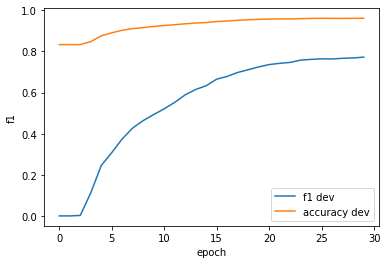

In [36]:
import numpy as np
from seqeval.metrics import f1_score
from seqeval.metrics import accuracy_score
import matplotlib.pyplot as plt

def get_pred(model, data_batch):
  corr_tag = []
  pred_tag = []

  for data in data_batch:
    words, case, tags = data
    words = np.asarray(words)
    case = np.asarray(case)
    pred_res = blstm.predict([words, case])
    pred_res = pred_res.argmax(axis=-1)

    for i, tag_sentence in enumerate(tags):
      for j, tag in enumerate(tag_sentence):
        if tag == tag2idx["PAD"]:
          break
      corr_tag.append([idx2tag[tag] for tag in tag_sentence[:j].tolist()])
      pred_tag.append([idx2tag[tag] for tag in pred_res[i][:j].tolist()])
  return pred_tag, corr_tag


def train(model):
  f1_dev_his = []
  acc_dev_his = []
  model.set_weights(init_weights)

  for epoch in range(EPOCH):
    print("Epoch {}/{}".format(epoch+1, EPOCH))
    for data in train_batch:
      word, case, tag = data
      model.train_on_batch(x=[word, case], y=tag)
    
    pred_tag, corr_tag = get_pred(model, dev_batch)
    accuracy = accuracy_score(corr_tag, pred_tag)
    f1 = f1_score(corr_tag, pred_tag)
    f1_dev_his.append(f1)
    acc_dev_his.append(accuracy)
    print("dev accuracy {}, f1 {}".format(accuracy, f1))
  
  print("{}\n{}".format(pred_tag[:3], corr_tag[:3]))
  plt.plot(f1_dev_his, label = "f1 dev")
  plt.plot(acc_dev_his, label = "accuracy dev")
  plt.xlabel("epoch")
  plt.ylabel("f1")
  plt.legend()
  plt.show()

  return model


blstm = train(blstm)

In [37]:
pred_tag, corr_tag = get_pred(blstm, train_batch)
f1 = f1_score(corr_tag, pred_tag)
acc = accuracy_score(corr_tag, pred_tag)
print("train_set f1:{}, accuracy{}".format(f1, acc))

pred_tag, corr_tag = get_pred(blstm, dev_batch)
f1 = f1_score(corr_tag, pred_tag)
acc = accuracy_score(corr_tag, pred_tag)
print("dev_set f1:{}, accuracy{}".format(f1, acc))

pred_tag, corr_tag = get_pred(blstm, test_batch)
f1 = f1_score(corr_tag, pred_tag)
acc = accuracy_score(corr_tag, pred_tag)
print("test_set f1:{}, accuracy{}".format(f1, acc))

train_set f1:0.9679003980689422, accuracy0.9952093934994403
dev_set f1:0.7722804988849427, accuracy0.9615339873589515
test_set f1:0.6617759959054849, accuracy0.9364848069258133


In [38]:
tag_list = [tag for tag_sentence in pred_tag for tag in tag_sentence]

def write_tag(file_name, tag):
  with open("/content/drive/MyDrive/data/test.txt", mode='rt', encoding="UTF8") as f:
    sentences = []
    sentence = []
    for line in f:
      line = line[:-1]
      if len(line) == 0 or line[0] == "\n":
        if len(sentence) > 0:
          sentences.append(sentence)
          sentence = []
        continue
      splits = line.split(' ')
      sentence.append(splits[:-1])

  if len(sentence) > 0:
    sentences.append(sentence)
    sentence = []

  with open(file_name, 'w') as f:
    for sentence_list in sentences:
      for sentence in sentence_list:
        for i, word in enumerate(sentence):
          f.write(word + ' ')
          if i == len(sentence)-1:
            f.write(tag.pop(0) + '\n')
      f.write('\n')

write_tag('3036033675.lstm.test.txt', tag_list)

build Transformer

In [110]:
epochs = 60
ntokens = len(word2idx)  # size of vocabulary
emsize = 90  # embedding dimension
d_hid = 100  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 3  # number of heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability
ntags = len(tag2idx)

In [40]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [111]:
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, ntag: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntag)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [112]:
import matplotlib.pyplot as plt
from seqeval.metrics import f1_score
from seqeval.metrics import accuracy_score

model = TransformerModel(ntokens, ntags, emsize, nhead, d_hid, nlayers, dropout).to(device)

criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)


def evaluate(dataset):
  model.eval()
  pred_tgt = []
  corr_tgt = []
  for data in dataset:
    src, _, tgt = data
    src = src.to(device)
    src_mask = generate_square_subsequent_mask(src.shape[0]).to(device)
    out = model(src, src_mask)
    pred = out.argmax(axis=-1)
    
    for i, tgt_sentence in enumerate(tgt):
      for j, tag in enumerate(tgt_sentence):
        if tag == tag2idx["PAD"]:
          break
      corr_tgt.append([idx2tag[tag] for tag in tgt_sentence[:j].tolist()])
      pred_tgt.append([idx2tag[tag] for tag in pred[i][:j].tolist()])
  f1 = f1_score(corr_tgt, pred_tgt)
  acc = accuracy_score(corr_tgt, pred_tgt)
  return f1, acc, pred_tgt


loss_his = []
f1_his = []
model.init_weights
model.train()
for epoch in range(epochs):
  print("Epoch {}/{}".format(epoch+1, epochs))

  for data in train_batch:
    src, _, tgt = data
    src = src.to(device)
    tgt = tgt.to(device)
    src_mask = generate_square_subsequent_mask(src.shape[0]).to(device)
    out = model(src, src_mask)
    tgt = torch.tensor(tgt, dtype = torch.int64)
    loss = criterion(out.view(-1, out.size(-1)), tgt.view(-1)) 
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()
    
  f1, _, _ = evaluate(dev_batch)
  scheduler.step()
  loss_his.append(loss)
  f1_his.append(f1)
  print("loss:{}, f1:{}".format(loss.item(), f1))
    



Epoch 1/60


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


loss:0.4776124656200409, f1:0.0
Epoch 2/60
loss:0.5907233953475952, f1:0.0
Epoch 3/60
loss:0.10341348499059677, f1:0.0
Epoch 4/60
loss:0.0767911747097969, f1:0.0
Epoch 5/60
loss:0.07576628774404526, f1:0.0
Epoch 6/60
loss:0.07541707158088684, f1:0.0
Epoch 7/60
loss:0.07503039389848709, f1:0.0
Epoch 8/60
loss:0.07467062026262283, f1:0.0
Epoch 9/60
loss:0.07445799559354782, f1:0.0
Epoch 10/60
loss:0.07432530075311661, f1:0.0
Epoch 11/60
loss:0.074068084359169, f1:0.0
Epoch 12/60
loss:0.0737815797328949, f1:0.0
Epoch 13/60
loss:0.07376991957426071, f1:0.0
Epoch 14/60
loss:0.07319092005491257, f1:0.0
Epoch 15/60
loss:0.07180755585432053, f1:0.0
Epoch 16/60
loss:0.07014074176549911, f1:0.0
Epoch 17/60
loss:0.06834074854850769, f1:0.0
Epoch 18/60
loss:0.06629345566034317, f1:0.002009713615809747
Epoch 19/60
loss:0.06425691395998001, f1:0.04946306540839571
Epoch 20/60
loss:0.062498755753040314, f1:0.10441267868241144
Epoch 21/60
loss:0.06100185588002205, f1:0.14249889364213011
Epoch 22/60
los

trian_set f1:0.44229490911591446, accuracy0.8941080428417095
dev_set f1:0.4154302670623145, accuracy0.883710108961185
test_set f1:0.39087880049979173, accuracy0.8721767453820769


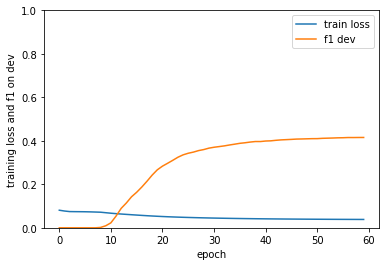

In [88]:
f1, acc, _ = evaluate(train_batch)
print("trian_set f1:{}, accuracy{}".format(f1, acc))
f1, acc, _ = evaluate(dev_batch)
print("dev_set f1:{}, accuracy{}".format(f1, acc))
f1, acc, pred_tgt = evaluate(test_batch)
print("test_set f1:{}, accuracy{}".format(f1, acc))

plt.plot(torch.tensor(loss_his, device='cpu'), label = "train loss")
plt.plot(torch.tensor(f1_his, device='cpu'), label = "f1 dev")
plt.ylim(0, 1)
plt.xlabel("epoch")
plt.ylabel("training loss and f1 on dev")
plt.legend()
plt.show()

In [85]:
tag_list = [tag for tag_sentence in pred_tgt for tag in tag_sentence]
write_tag('3036033675.transformer.test.txt', tag_list)

pre_trained word embedding:GloVe

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


dev accuracy 0.8311295513591066, f1 0.016740366392924828
Epoch 2/50
dev accuracy 0.8635658614137811, f1 0.2500303729801968
Epoch 3/50
dev accuracy 0.918550544805925, f1 0.5654085745694394
Epoch 4/50
dev accuracy 0.9359610686726899, f1 0.6522934203745062
Epoch 5/50
dev accuracy 0.9446663306060723, f1 0.6959939784226813
Epoch 6/50
dev accuracy 0.9476327116212339, f1 0.7089955895814263
Epoch 7/50
dev accuracy 0.9500756136337198, f1 0.721197584980564
Epoch 8/50
dev accuracy 0.9560665399976734, f1 0.7410624791179419
Epoch 9/50
dev accuracy 0.9580247392299043, f1 0.7563011042737924
Epoch 10/50
dev accuracy 0.9589553685679941, f1 0.7604236718224613
Epoch 11/50
dev accuracy 0.9601186552406065, f1 0.7627033372463524
Epoch 12/50
dev accuracy 0.9621544069176781, f1 0.7698075481129717
Epoch 13/50
dev accuracy 0.9621350188064679, f1 0.7708368130950393
Epoch 14/50
dev accuracy 0.9637636201481252, f1 0.7779807372965793
Epoch 15/50
dev accuracy 0.9651207879328396, f1 0.7862920036688068
Epoch 16/50
dev

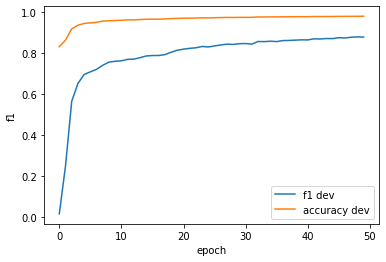

In [98]:
import numpy as np 

train = readfile("/content/drive/MyDrive/data/train.txt")
dev = readfile("/content/drive/MyDrive/data/valid.txt")
test = readfile("/content/drive/MyDrive/data/test.txt")

wordEmbedding = []
fEmbeddings = open("/content/drive/MyDrive/data/glove.6B.50d.txt", encoding="utf-8")
word2idx = {}

for line in fEmbeddings:
  split = line.strip().split(" ")
  word = split[0] 

  if len(word2idx) == 0:  
      word2idx["PAD"] = len(word2idx)
      vector = np.zeros(len(split) - 1)  
      wordEmbedding.append(vector)

      word2idx["UNK"] = len(word2idx)
      vector = np.random.uniform(-0.25, 0.25, len(split) - 1)
      wordEmbedding.append(vector)

  if split[0].lower() in words:
      vector = np.array([float(num) for num in split[1:]])
      wordEmbedding.append(vector)  
      word2idx[split[0]] = len(word2idx)

wordEmbedding = np.array(wordEmbedding)
idx2word = {i:w for w, i in word2idx.items()}

train_set = data2idx(train)
dev_set = data2idx(dev)
test_set = data2idx(test)

train_batch = get_batch(train_set[0], train_set[1], train_set[2], BATCH_SIZE)
test_batch = get_batch(test_set[0], test_set[1], test_set[2], BATCH_SIZE)
dev_batch = get_batch(dev_set[0], dev_set[1], dev_set[2], BATCH_SIZE)

word_in = Input(shape=(max_len,))
word_emb = Embedding(input_dim=wordEmbedding.shape[0], 
            output_dim=wordEmbedding.shape[1], 
            weights=[wordEmbedding], trainable=False, 
            input_length=max_len, mask_zero=True)(word_in)

out = concatenate([word_emb, case_emb])
out = Bidirectional(LSTM(units=LSTM_STATE_SIZE, return_sequences=True, 
              dropout=DROPOUT),
              name="BLSTM")(out)
out = TimeDistributed(Dense(len(tag2idx), activation="softmax"),name="Softmax_layer")(out)

blstm = Model(inputs=[word_in, case_in], outputs=[out])
blstm.compile(loss='sparse_categorical_crossentropy', optimizer="nadam")


f1_dev_his = []
acc_dev_his = []
EPOCH = 50

for epoch in range(EPOCH):
  print("Epoch {}/{}".format(epoch+1, EPOCH))
  for data in train_batch:
    word, case, tag = data
    blstm.train_on_batch(x=[word, case], y=tag)
  
  pred_tag, corr_tag = get_pred(model, dev_batch)
  accuracy = accuracy_score(corr_tag, pred_tag)
  f1 = f1_score(corr_tag, pred_tag)
  f1_dev_his.append(f1)
  acc_dev_his.append(accuracy)
  print("dev accuracy {}, f1 {}".format(accuracy, f1))

print("{}\n{}".format(pred_tag[:3], corr_tag[:3]))
plt.plot(f1_dev_his, label = "f1 dev")
plt.plot(acc_dev_his, label = "accuracy dev")
plt.xlabel("epoch")
plt.ylabel("f1")
plt.legend()
plt.show()


In [99]:
pred_tag, corr_tag = get_pred(blstm, train_batch)
f1 = f1_score(corr_tag, pred_tag)
acc = accuracy_score(corr_tag, pred_tag)
print("train_set f1:{}, accuracy{}".format(f1, acc))

pred_tag, corr_tag = get_pred(blstm, dev_batch)
f1 = f1_score(corr_tag, pred_tag)
acc = accuracy_score(corr_tag, pred_tag)
print("dev_set f1:{}, accuracy{}".format(f1, acc))

pred_tag, corr_tag = get_pred(blstm, test_batch)
f1 = f1_score(corr_tag, pred_tag)
acc = accuracy_score(corr_tag, pred_tag)
print("test_set f1:{}, accuracy{}".format(f1, acc))

tag_list = [tag for tag_sentence in pred_tag for tag in tag_sentence]
write_tag('3036033675.optional.test.txt', tag_list)

train_set f1:0.9261434720838017, accuracy0.9885269862685575
dev_set f1:0.878326359832636, accuracy0.9798363643413859
test_set f1:0.8291400017533095, accuracy0.9685424077486822
